<a href="https://colab.research.google.com/github/kimyuji/EMNIST_Challenge/blob/main/%ED%94%84%EB%A1%9C%EC%A0%9D%ED%8A%B8_1.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# 프로젝트

### 0. Define Hyperparameter

In [ ]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import Dataset, DataLoader, SubsetRandomSampler
import time
import matplotlib
import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from torchsummary import summary
import random
import pandas as pd
%matplotlib inline

## 1. Load Data

In [ ]:
np.random.seed(0)
torch.manual_seed(0)
torch.cuda.manual_seed(0)
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Hyper parameters
input_size = 28 # EMNIST:28*28*1
batch_size = 100
num_epochs = 6
split_ratio = 0.1 # train:valid
learning_rate=0.001

In [ ]:
class TypeData(Dataset):
  def __init__(self,train):
    super(TypeData, self).__init__()
    self.digit = 10
    self.letter = 46
    self.train = train

    self.data = torchvision.datasets.EMNIST(root='./',
                                        split='bymerge',
                                        train=self.train,
                                        transform = transforms.Compose([transforms.ToTensor()]),
                                        download=True)

  def __getitem__(self, index): # i번째 샘플
    if self.data[index][1] < self.digit:
      label = 0.
    else:
      label = 1.
    return self.data[index][0], label

  def __len__(self): #데이터셋 크기
    return len(self.data)


In [ ]:
train_data = TypeData(train=True)
test_data = TypeData(train=False)

In [ ]:
# image 확인
def image_show(dataset, num):
  fig = plt.figure(figsize=(30,30))

  for i in range(num):
    plt.subplot(1, num, i+1)
    plt.imshow(dataset[i][0].squeeze()) # input image
    plt.title(dataset[i][1]) # label : 0,1

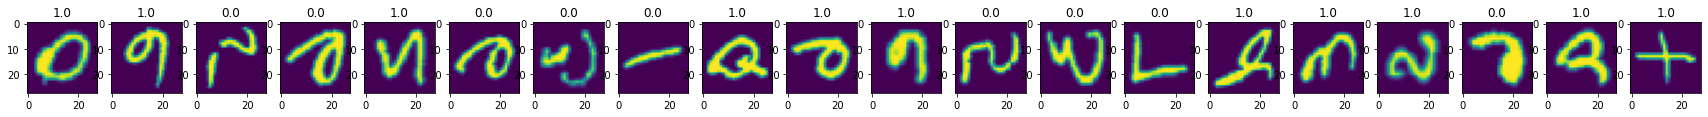

In [ ]:
image_show(train_data, 20)


## 2. Split train set and validation set

In [ ]:
data_size = len(train_data)
data_indices = list(range(data_size))
np.random.shuffle(data_indices) # shuffle하기
val_split_index = int(np.floor(split_ratio * data_size))
train_idx, val_idx = data_indices[val_split_index:], data_indices[:val_split_index]
train_sampler = SubsetRandomSampler(train_idx)
val_sampler = SubsetRandomSampler(val_idx)

In [ ]:
print(len(train_sampler))
print(len(val_sampler))

628139
69793


## 3. Define dataloader

In [ ]:
train_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           sampler=train_sampler) 
valid_loader = torch.utils.data.DataLoader(dataset=train_data,
                                           batch_size=batch_size,
                                           sampler=val_sampler) 

test_loader = torch.utils.data.DataLoader(dataset=test_data,
                                          batch_size=batch_size,
                                          shuffle=False)

In [ ]:
# cf) Check dataloader shape
image, label = next(iter(test_loader))
print(image.size()) 
print(label.size()) 
print(len(train_loader))
print(len(valid_loader))
print(len(test_loader))

torch.Size([100, 1, 28, 28])
torch.Size([100])
6282
698
1164


## 4. Define a model

In [ ]:
class model1(nn.Module):
  def __init__(self):
    super(model1, self).__init__()
    self.layer1 = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=10, kernel_size=3, stride=1, padding=1), #edge, all info
        nn.BatchNorm2d(10),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer2 = nn.Sequential(
        nn.Conv2d(in_channels=10, out_channels=50, kernel_size=5, stride=1, padding=1), # image의 특성
        nn.BatchNorm2d(50),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.layer3 = nn.Sequential(
        nn.Conv2d(in_channels=50, out_channels=100, kernel_size=5, stride=1, padding=1),
        nn.BatchNorm2d(100),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2)
    )
    self.dropout = nn.Dropout(0.2)
    self.fc = nn.Sequential(
        nn.Linear(2*2*100, 200),
        nn.Linear(200,100),
        nn.Linear(100,1),
        nn.Sigmoid()
    )
  def forward(self, input):
      out = self.layer1(input)
      out = self.layer2(out)
      out = self.layer3(out)
      out = out.reshape(out.size(0), -1)
      out = self.dropout(out)
      out = self.fc(out)

      return out.squeeze(1)

model = model1().to(device)

In [ ]:
print(model)

model1(
  (layer1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(10, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer2): Sequential(
    (0): Conv2d(10, 50, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(50, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (layer3): Sequential(
    (0): Conv2d(50, 100, kernel_size=(5, 5), stride=(1, 1), padding=(1, 1))
    (1): BatchNorm2d(100, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU()
    (3): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (dropout): Dropout(p=0.2, inplace=False)
  (fc): Sequential(
    (0): Linear(in_features=400, out_features=200, b

In [ ]:
criterion = nn.BCELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate) 

## 5. Define train and evaluate functions

In [ ]:
def train(model, train_loader, optimizer, criterion): 
  model.train() # train mode
  epoch_loss, acc, total = 0, 0, 0
  total_step = len(train_loader)
  for i, (image, label) in enumerate(train_loader):
    image = image.to(device)
    label = label.float().to(device)

    # Forward
    output = model(image)
    loss = criterion(output.float(), label)

    # Backward and optimize
    optimizer.zero_grad()
    loss.backward()
    optimizer.step()

    acc += (torch.round(output)==label).sum()
    epoch_loss += loss.item()
    total += len(label)

  return epoch_loss / len(train_loader), acc / total * 100


In [ ]:
def evaluate(model, data_loader, criterion):
  model.eval() # evaluation mode
  total=0
  with torch.no_grad(): #backprop 기능 끄기
    correct = 0
    epoch_loss = 0
    for img, lab in data_loader: 
      img = img.to(device)
      lab = lab.float().to(device)
      out = model(img)
      pred = torch.round(out)
      correct += (pred == lab).sum().item()
      loss = criterion(out.float(), lab)
      epoch_loss += loss.item()
      total += len(lab)
  return epoch_loss / len(data_loader), correct / total * 100


## 6. Train the model

In [ ]:
print("----------------------- start training ---------------------------")
start = time.time() 
best_valid_loss = float('inf') # 무한대로 초기화
best_epoch = 0
train_error=[]
valid_error=[]
train_accuracy=[]
valid_accuracy=[]
for epoch in range(num_epochs):
  train_loss, train_acc = train(model, train_loader, optimizer, criterion)
  valid_loss, valid_acc = evaluate(model, valid_loader, criterion)
  train_error.append(train_loss)
  valid_error.append(valid_loss)
  train_accuracy.append(train_acc.float())
  valid_accuracy.append(valid_acc)

  if valid_loss < best_valid_loss:
    best_valid_loss = valid_loss
    best_epoch = epoch
    torch.save(model.state_dict(), "epoch_{}.pth".format(epoch))

  print("Epoch[{}/{}], Train Loss:{:.4f}, Train Acc:{:.2f}, Valid Loss:{:.4f}, Valid Acc:{:.2f}".format(epoch+1, num_epochs,
                                                                                                        train_loss, train_acc,
                                                                                                        valid_loss, valid_acc))
result = pd.DataFrame([ x for x in zip(train_error, valid_error, train_accuracy, valid_accuracy)], 
                      index=[i+1 for i in range(num_epochs)],
                      columns=["train_error", "valid_error", "train_accuracy", "valid_accuracy"])  
end = time.time() # 마지막 
print("Train takes {:.2f}minutes".format((end-start)/60)) # 시간 출력
print("----------------------- training ended ---------------------------")

----------------------- start training ---------------------------
Epoch[1/6], Train Loss:0.2315, Train Acc:89.66, Valid Loss:0.1981, Valid Acc:90.82
Epoch[2/6], Train Loss:0.1859, Train Acc:91.71, Valid Loss:0.1757, Valid Acc:92.01
Epoch[3/6], Train Loss:0.1740, Train Acc:92.20, Valid Loss:0.1745, Valid Acc:92.29
Epoch[4/6], Train Loss:0.1667, Train Acc:92.51, Valid Loss:0.1705, Valid Acc:92.38
Epoch[5/6], Train Loss:0.1617, Train Acc:92.70, Valid Loss:0.1701, Valid Acc:92.31
Epoch[6/6], Train Loss:0.1577, Train Acc:92.85, Valid Loss:0.1676, Valid Acc:92.47
Train takes 12.92minutes
----------------------- training ended ---------------------------


In [ ]:
model.load_state_dict(torch.load('./epoch_{}.pth'.format(best_epoch)))
torch.save(model.state_dict(), "model1.pth")

## 7. Check loss function

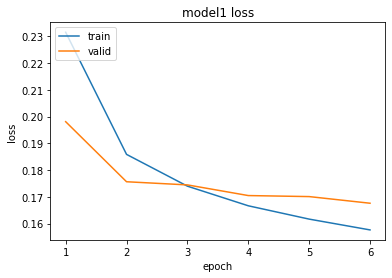

In [ ]:
plt.plot(result['train_error'])
plt.plot(result['valid_error'])
plt.title('model1 loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

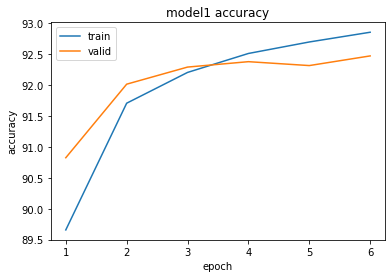

In [ ]:
plt.plot(result['train_accuracy'])
plt.plot(result['valid_accuracy'])
plt.title('model1 accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

## 8. Evaluate the model

In [ ]:
model.load_state_dict(torch.load('model1.pth'))

test_loss, test_acc = evaluate(model, test_loader, criterion)
print("Test Accuracy:{:.2f}% (Loss:{:.4f})".format(test_acc, test_loss))

Test Accuracy:92.66% (Loss:0.1645)


In [ ]:
print(best_epoch)

5
